In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

import re
import sys
import pickle
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from data_loader import get_loader
from torchvision import transforms
from margin_exp import train_model, plot
from network import ResNet18, ResNet, CNN
import scipy.stats
import seaborn as sns
#import seaborn; seaborn.set()
import scipy.stats
from utils import AverageMeter, accuracy, get_margin, ramp_loss, margin_error


use_gpu = torch.cuda.is_available()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ResNet - Learning rate 0.01 - 10% noise

In [3]:
# %%
root = './data'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'partially-0.1'

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(
                                         (0.4914, 0.4822, 0.4465),
                                         (0.2023, 0.1994, 0.2010))])
(training_dataset, testing_dataset), \
(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms)

loaders = {'train': training_loader, 'test': testing_loader}

# %% run the model
num_epochs = 100
model = ResNet18(num_classes=10)

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=lr, betas=(.9, .999))
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

model_01_1, log_01_1 = train_model(model, criterion, optimizer, loaders, 
                               num_epochs=100, verbose=True, net='Res18')

****** label mode: partially-0.1 ******
total parameters: 11173962
Epoch 1/100
----------
train1: CrossEntropy: 1.5150, Error: 0.5174, Lip(PowIter):0.2668
test: CrossEntropy: 1.5636, Error: 0.5307, Lip(PowIter):0.2668
Epoch 2/100
----------
train1: CrossEntropy: 1.3103, Error: 0.4249, Lip(PowIter):0.1395
test: CrossEntropy: 1.3920, Error: 0.4522, Lip(PowIter):0.1395
Epoch 3/100
----------
train1: CrossEntropy: 1.1279, Error: 0.3511, Lip(PowIter):0.1040
test: CrossEntropy: 1.2913, Error: 0.4033, Lip(PowIter):0.1040
Epoch 4/100
----------
train1: CrossEntropy: 0.9919, Error: 0.3017, Lip(PowIter):0.0876
test: CrossEntropy: 1.2671, Error: 0.3907, Lip(PowIter):0.0876
Epoch 5/100
----------
train1: CrossEntropy: 0.8806, Error: 0.2640, Lip(PowIter):0.0818
test: CrossEntropy: 1.2924, Error: 0.3834, Lip(PowIter):0.0818
Epoch 6/100
----------
train1: CrossEntropy: 0.7213, Error: 0.2182, Lip(PowIter):0.0750
test: CrossEntropy: 1.3066, Error: 0.3799, Lip(PowIter):0.0750
Epoch 7/100
----------
trai

test: CrossEntropy: 1.8883, Error: 0.3471, Lip(PowIter):0.0693
Epoch 55/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(PowIter):0.0694
test: CrossEntropy: 1.8913, Error: 0.3464, Lip(PowIter):0.0694
Epoch 56/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(PowIter):0.0693
test: CrossEntropy: 1.9004, Error: 0.3460, Lip(PowIter):0.0693
Epoch 57/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(PowIter):0.0695
test: CrossEntropy: 1.9000, Error: 0.3470, Lip(PowIter):0.0695
Epoch 58/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(PowIter):0.0703
test: CrossEntropy: 1.8968, Error: 0.3472, Lip(PowIter):0.0703
Epoch 59/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(PowIter):0.0694
test: CrossEntropy: 1.8982, Error: 0.3477, Lip(PowIter):0.0694
Epoch 60/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(PowIter):0.0698
test: CrossEntropy: 1.9058, Error: 0.3473, Lip(PowIter):0.0698
Epoch 61/100
----------
t

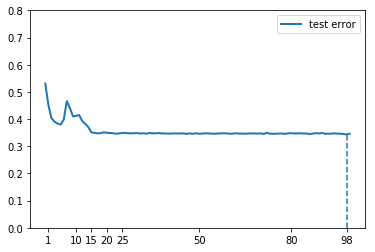

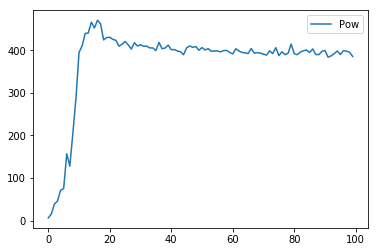

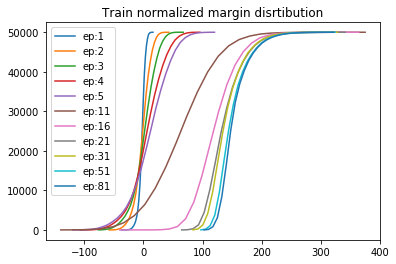

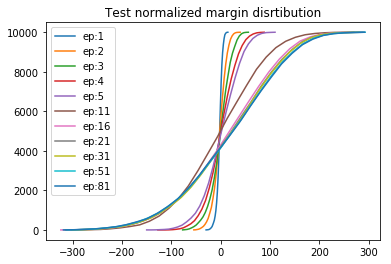

In [10]:
log = log_01_1

#plt.plot(log['train_error'], linewidth=2, label='training')

plt.plot(log['test_error'], linewidth=2, label='test error', c='C0')
min_idx_1 = np.argmin(log['test_error'])
plt.plot([min_idx_1, min_idx_1], [0, log['test_error'][min_idx_1]], '--', c='C0' )
plt.ylim(0,.8)
plt.xticks([1, min_idx_1, 10, 15, 20, 25, 50, 80], [1, min_idx_1, 10, 15, 20, 25, 50, 80])
plt.legend()
plt.show()

q = 1.0
#plt.plot(log_03['test_error'], label='error')
#nmargin_l1 = np.array(log_03['train_dist_margin'])/np.array(log_03['lip_l1']).reshape(100,1)
#plt.plot(np.quantile(nmargin_l1, q, axis=1)*100, label='L1')
plt.plot(log_03['train_qnmargin_%.1f'%q], label='Pow')
plt.legend()
plt.show()


ep_list = [0, 1,2,3,4,10,15,20,30,50,80]
for ep in ep_list:
    value, base = np.histogram(log['train_dist_nmargin'][ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    plt.legend()
    plt.title('Train normalized margin disrtibution')
plt.show()

for ep in ep_list:
    value, base = np.histogram(log['test_dist_nmargin'][ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    plt.legend()
    plt.title('Test normalized margin disrtibution')
plt.show()


ResNet - Learning rate 0.001 - 10% noise

In [4]:
# %%
root = './data'
lr = 0.001
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'partially-0.1'

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(
                                         (0.4914, 0.4822, 0.4465),
                                         (0.2023, 0.1994, 0.2010))])
(training_dataset, testing_dataset), \
(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms)

loaders = {'train': training_loader, 'test': testing_loader}

# %% run the model
num_epochs = 100
model = ResNet18(num_classes=10)

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=lr, betas=(.9, .999))
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

model_01_2, log_01_2 = train_model(model, criterion, optimizer, loaders, 
                               num_epochs=100, verbose=True, net='Res18')

****** label mode: partially-0.1 ******
total parameters: 11173962
Epoch 1/100
----------
train1: CrossEntropy: 1.9296, Error: 0.6877, Lip(PowIter):1.4117
test: CrossEntropy: 1.9395, Error: 0.6933, Lip(PowIter):1.4117
Epoch 2/100
----------
train1: CrossEntropy: 1.7767, Error: 0.6243, Lip(PowIter):1.1876
test: CrossEntropy: 1.7922, Error: 0.6340, Lip(PowIter):1.1876
Epoch 3/100
----------
train1: CrossEntropy: 1.6761, Error: 0.5858, Lip(PowIter):1.1447
test: CrossEntropy: 1.6929, Error: 0.5903, Lip(PowIter):1.1447
Epoch 4/100
----------
train1: CrossEntropy: 1.5955, Error: 0.5469, Lip(PowIter):1.0594
test: CrossEntropy: 1.6186, Error: 0.5580, Lip(PowIter):1.0594
Epoch 5/100
----------
train1: CrossEntropy: 1.5514, Error: 0.5261, Lip(PowIter):1.0711
test: CrossEntropy: 1.5768, Error: 0.5389, Lip(PowIter):1.0711
Epoch 6/100
----------
train1: CrossEntropy: 1.4776, Error: 0.4933, Lip(PowIter):1.0954
test: CrossEntropy: 1.5165, Error: 0.5067, Lip(PowIter):1.0954
Epoch 7/100
----------
trai

test: CrossEntropy: 2.1829, Error: 0.4632, Lip(PowIter):1.3221
Epoch 55/100
----------
train1: CrossEntropy: 0.0032, Error: 0.0000, Lip(PowIter):1.3282
test: CrossEntropy: 2.0889, Error: 0.4522, Lip(PowIter):1.3282
Epoch 56/100
----------
train1: CrossEntropy: 0.0040, Error: 0.0000, Lip(PowIter):1.3338
test: CrossEntropy: 2.1398, Error: 0.4613, Lip(PowIter):1.3338
Epoch 57/100
----------
train1: CrossEntropy: 0.0032, Error: 0.0000, Lip(PowIter):1.3218
test: CrossEntropy: 2.1302, Error: 0.4602, Lip(PowIter):1.3218
Epoch 58/100
----------
train1: CrossEntropy: 0.0031, Error: 0.0000, Lip(PowIter):1.3313
test: CrossEntropy: 2.1322, Error: 0.4584, Lip(PowIter):1.3313
Epoch 59/100
----------
train1: CrossEntropy: 0.0025, Error: 0.0000, Lip(PowIter):1.3601
test: CrossEntropy: 2.1178, Error: 0.4562, Lip(PowIter):1.3601
Epoch 60/100
----------
train1: CrossEntropy: 0.0024, Error: 0.0000, Lip(PowIter):1.3401
test: CrossEntropy: 2.1577, Error: 0.4528, Lip(PowIter):1.3401
Epoch 61/100
----------
t

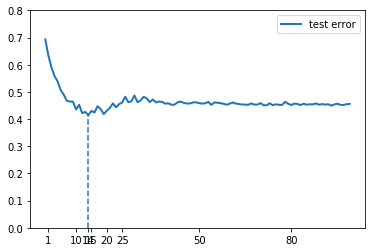

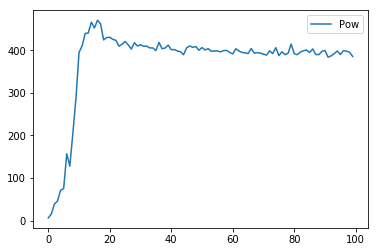

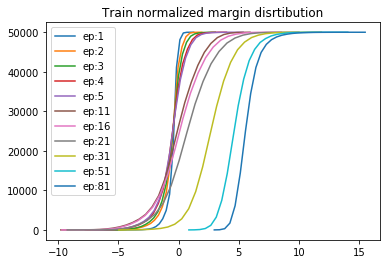

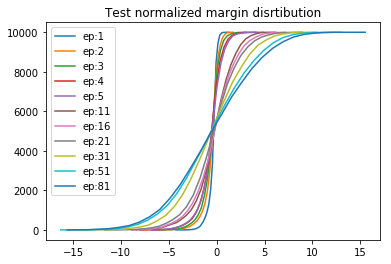

In [11]:
log = log_01_2

#plt.plot(log['train_error'], linewidth=2, label='training')

plt.plot(log['test_error'], linewidth=2, label='test error', c='C0')
min_idx_1 = np.argmin(log['test_error'])
plt.plot([min_idx_1, min_idx_1], [0, log['test_error'][min_idx_1]], '--', c='C0' )
plt.ylim(0,.8)
plt.xticks([1, min_idx_1, 10, 15, 20, 25, 50, 80], [1, min_idx_1, 10, 15, 20, 25, 50, 80])
plt.legend()
plt.show()

q = 1.0
#plt.plot(log_03['test_error'], label='error')
#nmargin_l1 = np.array(log_03['train_dist_margin'])/np.array(log_03['lip_l1']).reshape(100,1)
#plt.plot(np.quantile(nmargin_l1, q, axis=1)*100, label='L1')
plt.plot(log_03['train_qnmargin_%.1f'%q], label='Pow')
plt.legend()
plt.show()


ep_list = [0, 1,2,3,4,10,15,20,30,50,80]
for ep in ep_list:
    value, base = np.histogram(log['train_dist_nmargin'][ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    plt.legend()
    plt.title('Train normalized margin disrtibution')
plt.show()

for ep in ep_list:
    value, base = np.histogram(log['test_dist_nmargin'][ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    plt.legend()
    plt.title('Test normalized margin disrtibution')
plt.show()


ResNet - Learning rate 0.01 - 0% noise

In [5]:
# %%
root = './data'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'original'

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(
                                         (0.4914, 0.4822, 0.4465),
                                         (0.2023, 0.1994, 0.2010))])
(training_dataset, testing_dataset), \
(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms)

loaders = {'train': training_loader, 'test': testing_loader}

# %% run the model
num_epochs = 100
model = ResNet18(num_classes=10)

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=lr, betas=(.9, .999))
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

model_00, log_00 = train_model(model, criterion, optimizer, loaders, 
                               num_epochs=100, verbose=True, net='Res18')

****** label mode: original ******
total parameters: 11173962
Epoch 1/100
----------
train1: CrossEntropy: 1.2462, Error: 0.4501, Lip(PowIter):0.3763
test: CrossEntropy: 1.2991, Error: 0.4709, Lip(PowIter):0.3763
Epoch 2/100
----------
train1: CrossEntropy: 0.9289, Error: 0.3260, Lip(PowIter):0.1747
test: CrossEntropy: 1.0129, Error: 0.3571, Lip(PowIter):0.1747
Epoch 3/100
----------
train1: CrossEntropy: 0.7179, Error: 0.2546, Lip(PowIter):0.1311
test: CrossEntropy: 0.8680, Error: 0.3065, Lip(PowIter):0.1311
Epoch 4/100
----------
train1: CrossEntropy: 0.7088, Error: 0.2489, Lip(PowIter):0.1087
test: CrossEntropy: 0.9386, Error: 0.3164, Lip(PowIter):0.1087
Epoch 5/100
----------
train1: CrossEntropy: 0.4978, Error: 0.1651, Lip(PowIter):0.1161
test: CrossEntropy: 0.8240, Error: 0.2764, Lip(PowIter):0.1161
Epoch 6/100
----------
train1: CrossEntropy: 0.2960, Error: 0.0994, Lip(PowIter):0.1189
test: CrossEntropy: 0.7426, Error: 0.2509, Lip(PowIter):0.1189
Epoch 7/100
----------
train1: C

test: CrossEntropy: 0.8720, Error: 0.2032, Lip(PowIter):0.1386
Epoch 55/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(PowIter):0.1386
test: CrossEntropy: 0.8731, Error: 0.2055, Lip(PowIter):0.1386
Epoch 56/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(PowIter):0.1359
test: CrossEntropy: 0.8748, Error: 0.2051, Lip(PowIter):0.1359
Epoch 57/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(PowIter):0.1379
test: CrossEntropy: 0.8760, Error: 0.2062, Lip(PowIter):0.1379
Epoch 58/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(PowIter):0.1370
test: CrossEntropy: 0.8824, Error: 0.2055, Lip(PowIter):0.1370
Epoch 59/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(PowIter):0.1378
test: CrossEntropy: 0.8804, Error: 0.2042, Lip(PowIter):0.1378
Epoch 60/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(PowIter):0.1396
test: CrossEntropy: 0.8850, Error: 0.2047, Lip(PowIter):0.1396
Epoch 61/100
----------
t

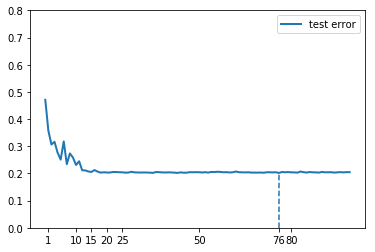

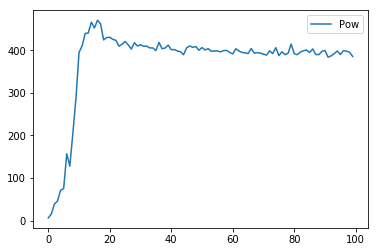

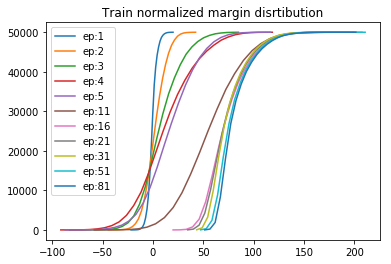

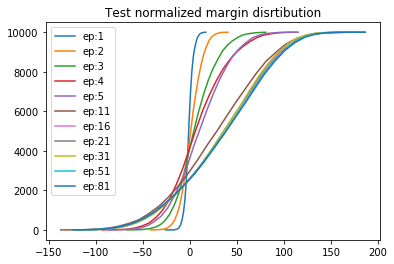

In [12]:
log = log_00

#plt.plot(log['train_error'], linewidth=2, label='training')

plt.plot(log['test_error'], linewidth=2, label='test error', c='C0')
min_idx_1 = np.argmin(log['test_error'])
plt.plot([min_idx_1, min_idx_1], [0, log['test_error'][min_idx_1]], '--', c='C0' )
plt.ylim(0,.8)
plt.xticks([1, min_idx_1, 10, 15, 20, 25, 50, 80], [1, min_idx_1, 10, 15, 20, 25, 50, 80])
plt.legend()
plt.show()

q = 1.0
#plt.plot(log_03['test_error'], label='error')
#nmargin_l1 = np.array(log_03['train_dist_margin'])/np.array(log_03['lip_l1']).reshape(100,1)
#plt.plot(np.quantile(nmargin_l1, q, axis=1)*100, label='L1')
plt.plot(log_03['train_qnmargin_%.1f'%q], label='Pow')
plt.legend()
plt.show()


ep_list = [0, 1,2,3,4,10,15,20,30,50,80]
for ep in ep_list:
    value, base = np.histogram(log['train_dist_nmargin'][ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    plt.legend()
    plt.title('Train normalized margin disrtibution')
plt.show()

for ep in ep_list:
    value, base = np.histogram(log['test_dist_nmargin'][ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    plt.legend()
    plt.title('Test normalized margin disrtibution')
plt.show()


ResNet - Learning rate 0.01 - 30% noise

In [6]:
# %%
root = './data'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'partially-0.3'

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(
                                         (0.4914, 0.4822, 0.4465),
                                         (0.2023, 0.1994, 0.2010))])
(training_dataset, testing_dataset), \
(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms)

loaders = {'train': training_loader, 'test': testing_loader}

# %% run the model
num_epochs = 100
model = ResNet18(num_classes=10)

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=lr, betas=(.9, .999))
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

model_03, log_03 = train_model(model, criterion, optimizer, loaders, 
                               num_epochs=100, verbose=True, net='Res18')

****** label mode: partially-0.3 ******
total parameters: 11173962
Epoch 1/100
----------
train1: CrossEntropy: 1.8432, Error: 0.6132, Lip(PowIter):0.6084
test: CrossEntropy: 1.8663, Error: 0.6190, Lip(PowIter):0.6084
Epoch 2/100
----------
train1: CrossEntropy: 1.7103, Error: 0.5405, Lip(PowIter):0.2954
test: CrossEntropy: 1.7745, Error: 0.5635, Lip(PowIter):0.2954
Epoch 3/100
----------
train1: CrossEntropy: 1.6925, Error: 0.5324, Lip(PowIter):0.1754
test: CrossEntropy: 1.8116, Error: 0.5671, Lip(PowIter):0.1754
Epoch 4/100
----------
train1: CrossEntropy: 1.5282, Error: 0.4645, Lip(PowIter):0.1293
test: CrossEntropy: 1.7262, Error: 0.5239, Lip(PowIter):0.1293
Epoch 5/100
----------
train1: CrossEntropy: 1.4555, Error: 0.4457, Lip(PowIter):0.1087
test: CrossEntropy: 1.8179, Error: 0.5357, Lip(PowIter):0.1087
Epoch 6/100
----------
train1: CrossEntropy: 1.2397, Error: 0.3774, Lip(PowIter):0.1040
test: CrossEntropy: 1.8124, Error: 0.5376, Lip(PowIter):0.1040
Epoch 7/100
----------
trai

test: CrossEntropy: 3.1842, Error: 0.5571, Lip(PowIter):0.0646
Epoch 55/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(PowIter):0.0649
test: CrossEntropy: 3.1907, Error: 0.5564, Lip(PowIter):0.0649
Epoch 56/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(PowIter):0.0650
test: CrossEntropy: 3.1951, Error: 0.5585, Lip(PowIter):0.0650
Epoch 57/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(PowIter):0.0657
test: CrossEntropy: 3.2196, Error: 0.5580, Lip(PowIter):0.0657
Epoch 58/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(PowIter):0.0652
test: CrossEntropy: 3.2072, Error: 0.5571, Lip(PowIter):0.0652
Epoch 59/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(PowIter):0.0645
test: CrossEntropy: 3.1900, Error: 0.5571, Lip(PowIter):0.0645
Epoch 60/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(PowIter):0.0654
test: CrossEntropy: 3.2194, Error: 0.5569, Lip(PowIter):0.0654
Epoch 61/100
----------
t

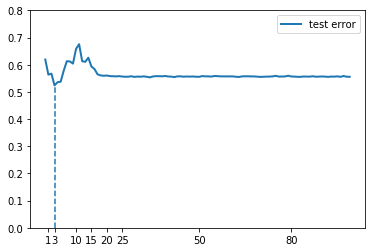

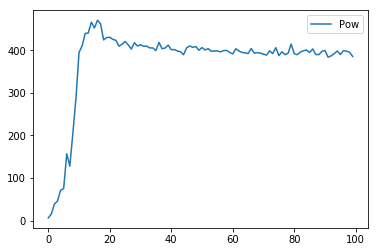

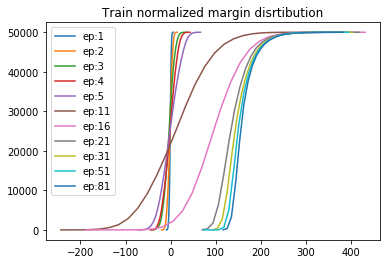

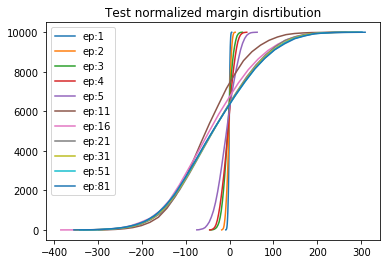

In [13]:
log = log_03

#plt.plot(log['train_error'], linewidth=2, label='training')

plt.plot(log['test_error'], linewidth=2, label='test error', c='C0')
min_idx_1 = np.argmin(log['test_error'])
plt.plot([min_idx_1, min_idx_1], [0, log['test_error'][min_idx_1]], '--', c='C0' )
plt.ylim(0,.8)
plt.xticks([1, min_idx_1, 10, 15, 20, 25, 50, 80], [1, min_idx_1, 10, 15, 20, 25, 50, 80])
plt.legend()
plt.show()

q = 1.0
#plt.plot(log_03['test_error'], label='error')
#nmargin_l1 = np.array(log_03['train_dist_margin'])/np.array(log_03['lip_l1']).reshape(100,1)
#plt.plot(np.quantile(nmargin_l1, q, axis=1)*100, label='L1')
plt.plot(log_03['train_qnmargin_%.1f'%q], label='Pow')
plt.legend()
plt.show()


ep_list = [0, 1,2,3,4,10,15,20,30,50,80]
for ep in ep_list:
    value, base = np.histogram(log['train_dist_nmargin'][ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    plt.legend()
    plt.title('Train normalized margin disrtibution')
plt.show()

for ep in ep_list:
    value, base = np.histogram(log['test_dist_nmargin'][ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    plt.legend()
    plt.title('Test normalized margin disrtibution')
plt.show()


In [3]:
# %%
root = './data'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'partially-0.3'

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(
                                         (0.4914, 0.4822, 0.4465),
                                         (0.2023, 0.1994, 0.2010))])
(training_dataset, testing_dataset), \
(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms)

loaders = {'train': training_loader, 'test': testing_loader}

# %% run the model
num_epochs = 100
model = ResNet18(num_classes=10)

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=lr, betas=(.9, .999))
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

model_03_1, log_03_1 = train_model(model, criterion, optimizer, loaders, 
                               num_epochs=100, verbose=True, net='Res18')

****** label mode: partially-0.3 ******
total parameters: 11173962
Epoch 1/100
----------
train1: CrossEntropy: 1.8641, Error: 0.6182, Lip(PowIter):0.2266
test: CrossEntropy: 1.8869, Error: 0.6329, Lip(PowIter):0.2266
Epoch 2/100
----------
train1: CrossEntropy: 1.7490, Error: 0.5578, Lip(PowIter):0.2260
test: CrossEntropy: 1.8108, Error: 0.5806, Lip(PowIter):0.2260
Epoch 3/100
----------
train1: CrossEntropy: 1.6697, Error: 0.5236, Lip(PowIter):0.2316
test: CrossEntropy: 1.7648, Error: 0.5579, Lip(PowIter):0.2316
Epoch 4/100
----------
train1: CrossEntropy: 1.6255, Error: 0.5056, Lip(PowIter):0.2380
test: CrossEntropy: 1.8118, Error: 0.5609, Lip(PowIter):0.2380
Epoch 5/100
----------
train1: CrossEntropy: 1.4708, Error: 0.4558, Lip(PowIter):0.2591
test: CrossEntropy: 1.8107, Error: 0.5617, Lip(PowIter):0.2591
Epoch 6/100
----------
train1: CrossEntropy: 1.3192, Error: 0.4076, Lip(PowIter):0.2626
test: CrossEntropy: 1.8437, Error: 0.5548, Lip(PowIter):0.2626
Epoch 7/100
----------
trai

test: CrossEntropy: 3.1476, Error: 0.5578, Lip(PowIter):0.4488
Epoch 55/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(PowIter):0.4429
test: CrossEntropy: 3.1458, Error: 0.5552, Lip(PowIter):0.4429
Epoch 56/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(PowIter):0.4441
test: CrossEntropy: 3.1586, Error: 0.5565, Lip(PowIter):0.4441
Epoch 57/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(PowIter):0.4455
test: CrossEntropy: 3.1584, Error: 0.5552, Lip(PowIter):0.4455
Epoch 58/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(PowIter):0.4414
test: CrossEntropy: 3.1418, Error: 0.5568, Lip(PowIter):0.4414
Epoch 59/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(PowIter):0.4409
test: CrossEntropy: 3.1613, Error: 0.5576, Lip(PowIter):0.4409
Epoch 60/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(PowIter):0.4427
test: CrossEntropy: 3.1587, Error: 0.5569, Lip(PowIter):0.4427
Epoch 61/100
----------
t

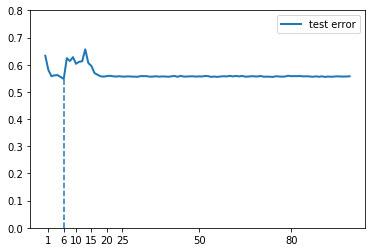

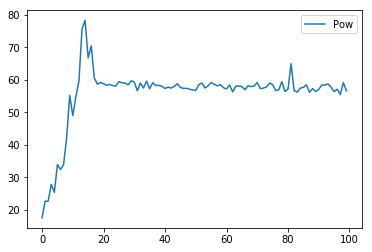

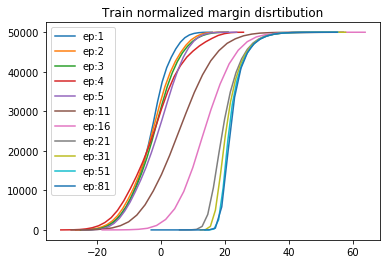

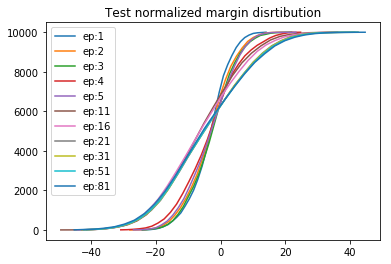

In [10]:
log = log_03_1

#plt.plot(log['train_error'], linewidth=2, label='training')

plt.plot(log['test_error'], linewidth=2, label='test error', c='C0')
min_idx_1 = np.argmin(log['test_error'])
plt.plot([min_idx_1, min_idx_1], [0, log['test_error'][min_idx_1]], '--', c='C0' )
plt.ylim(0,.8)
plt.xticks([1, min_idx_1, 10, 15, 20, 25, 50, 80], [1, min_idx_1, 10, 15, 20, 25, 50, 80])
plt.legend()
plt.show()

q = 1.
#plt.plot(log_03['test_error'], label='error')
#nmargin_l1 = np.array(log_03['train_dist_margin'])/np.array(log_03['lip_l1']).reshape(100,1)
#plt.plot(np.quantile(nmargin_l1, q, axis=1)*100, label='L1')
plt.plot(log['train_qnmargin_%.1f'%q], label='Pow')
plt.legend()
plt.show()


ep_list = [0, 1,2,3,4,10,15,20,30,50,80]
for ep in ep_list:
    value, base = np.histogram(log['train_dist_nmargin'][ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    plt.legend()
    plt.title('Train normalized margin disrtibution')
plt.show()

for ep in ep_list:
    value, base = np.histogram(log['test_dist_nmargin'][ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    plt.legend()
    plt.title('Test normalized margin disrtibution')
plt.show()


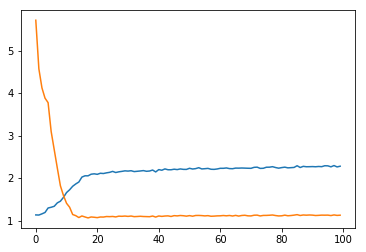

In [22]:
plt.plot(np.array(log['lip_pow']) *5 )
plt.plot(np.array(log['lip_l1'])/(10**33))